# Othello GPT Notes
## By: Ivan Vega with LLM support
### Completely written by Ivan Vega but conversations and explanation done by LLMs (ChatGPT-5, Claude, Gemini)

In [3]:
# libraries

import numpy as np
import torch
import torch.nn as nn
import scipy as stats
import matplotlib.pyplot as plt
%matplotlib inline

# Setting random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

### Step 1: Understanding and Affine Transformation
First lest try to understand what an Affine transformation is. I might be wrong but the basic idea is that it is a linear transformation (map) with a shift. A simple example then is:
$$ f(x) = Wx + b $$
In this case the linear transformation is of input $x$ would be peformed by the weight matrix $W$ and the shift would be done by the bias vector $b$.

While trying to understand the difference between linear and affine, a key example talking with and LLM is the linear transformation follow two properties for any vector $x$ and $y$ and any scalar $c$:
* Additivity: $f(x + y) = f(x) + f(y)$
* Homogeneity: $f(cx) = cf(x)$

A simple perceptron of the like $f(x) = Wx + b$ will break the homogeneity rule, because it would not map the zero vector to the zero vector again like $f(0) = 0$

In a way linear transformations scales, rotates and shears but the translation is done by the bias

Lets look at an example:

***Visualization***
numpy x:[0.88226926 0.91500396 0.38286376] and numpy h:[2.303093  1.8804536 1.941021 ]


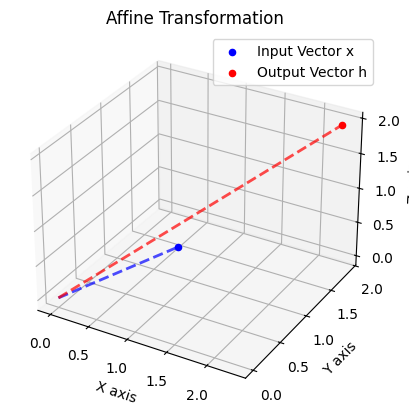

In [4]:
# Example of Affine Transformation
R = 3 # input dimension
D = 3 # output dimension
x = torch.rand(R) # create a random vector
W = torch.rand(D,R) # Weight matrix (output dim, input dim)
b = torch.rand(D) # #create random bias vector
h = W@x + b # Affine transformation

# print(f'input vector: {x}')
# print(f'weight matrix: {W}')
# print(f'weight bias vector: {b}')
# print(f'affine transformed vector:{h}')

# Transforming vectors to numpy format
x_np = x.numpy()
h_np = h.numpy()
print('***Visualization***')
print(f'numpy x:{x_np} and numpy h:{h_np}')

# Create the plot and plot the two points
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
v1 = ax.scatter(x_np[0],x_np[1],x_np[2],color="blue",label="Input Vector x")
v2 = ax.scatter(h_np[0],h_np[1],h_np[2], color="red",label="Output Vector h")

# Add lables and legends
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()
ax.set_title('Affine Transformation')

# Add arrows from origint to each point
ax.plot([0, x_np[0]], [0, x_np[1]], [0, x_np[2]],
          color='blue', linewidth=2, alpha=0.7, linestyle='--')
ax.plot([0, h_np[0]], [0, h_np[1]], [0, h_np[2]],
          color='red', linewidth=2, alpha=0.7, linestyle='--')

plt.show()

### Step 2: Understanding nonlinearity
There is a great blog on LLMs and how they work written by Stephen Wolfram on [how ChatGPT works](https://writings.stephenwolfram.com/2023/02/what-is-chatgpt-doing-and-why-does-it-work/) and he has a great explanation on non-lineariy, the gist of it is to imagine a basic classification example. First lets consider an xy-plane, were there are four sets of points that have different caracteristics described by a variable x and a variable y. If we plot these items in the xy-plane we could see something like the following picture:

![following picture:](https://github.com/paiv1991/nanothello/blob/main/assets/four_clusters.png?raw=1)

Now want to find a why to classify any input (x,y) and figure out to what cluster is it closest to in 2D space. Now here is where you will be able to notice why a linear prediction model would not yield promising results. If we use a simple linear model $y = Wx + b$ we will notice that it will fail to classify input (x,y) into the 4 different cluster correctly because it would divide the (x,y) plane in two sub-spaces thorugh one hyperplane or in this case one line decision boundary as seen in the following picture:

![following picture.](https://github.com/paiv1991/nanothello/blob/main/assets/linear_boundary.png?raw=1)

In this example the boundary decision will be a simple $x=y$ function that will be able to classify correctly a $[blue,red]$ but will fail in classifying $[orange,green]$. This is the reason why we opt for a non-linear model through an activation function (ReLU is the best example) so that it can classify the x,plane into many regions

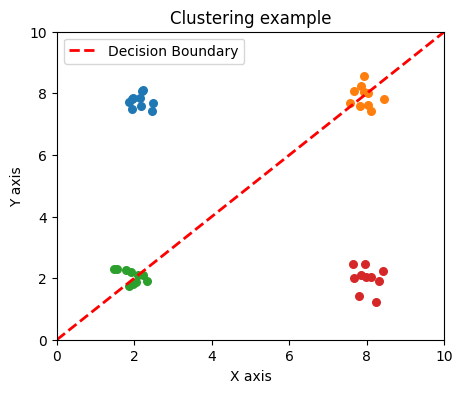

In [5]:
#Create an xy plane without any plots
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(5,4))
ax.axis((0,10,0,10))
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title('Clustering example')


# Cluster of dots
def sample_cluster(center_xy, n=10, spread=0.3):
    """
    center_xy: (x,y) tuple for the cluster center
    n: number of points to be created
    spread: how tight the cluster is
    """
    cx,cy = center_xy
    pts = np.column_stack([
        np.random.normal(cx, spread, n),
        np.random.normal(cy, spread, n)
    ])
    return pts

# Choose the centers of the clusters
centers = [
    (2,8), # top right
    (8,8), # top left
    (2,2), # bottom right
    (8,2) # bottom left
]

for c in centers:
    vectors = sample_cluster(c,n=10,spread=0.3)
    ax.scatter(vectors[:,0],vectors[:,1], s=30)

# Adding a trend line (decision boundary)

x_line = np.linspace(0,10,5)
y_line = x_line.copy()
ax.plot(x_line,y_line,'--',color='red', linewidth=2,label="Decision Boundary")

ax.legend()
plt.show()

### Step 3: Implementing ReLU

Now lets learn about ReLU by implementing it. Without ReLU creating multiple layers of networks would be pointless, as all of the layers would collapse into one overarching affine or linear transformation. This can be observed mathematically as follows:

Assume you have two neural network layers:$$(1)\hspace{0.1cm} z = W_{1}\textbf{x} + b_{1}$$  
$$(2)\hspace{0.1cm} y = W_{2}\textbf{z} + b_{2}\$$

Then the formula can collapse into one linear transformation:
$$y = W_{1}(W_{2}\textbf{x} + b_{2}) + b_{1} = (W_{2}W_{1})\textbf{x} + (W_{2}b_{1}+b_{2})$$

So to make this all work we need to add a activation function ReLU to add nonlinearity, in this case the activation formula is:

$$f(x) = \max(0, x) = \begin{cases}
0 & \text{for } x < 0 \\
x & \text{for } x \ge 0
\end{cases}$$

Lets build it from scratch to learn the intuition and then see the pytorch code later on to compare

ReLU([-2, -1, 0, 1, 2]) = [0 0 0 1 2]
ReLU(56) = 56


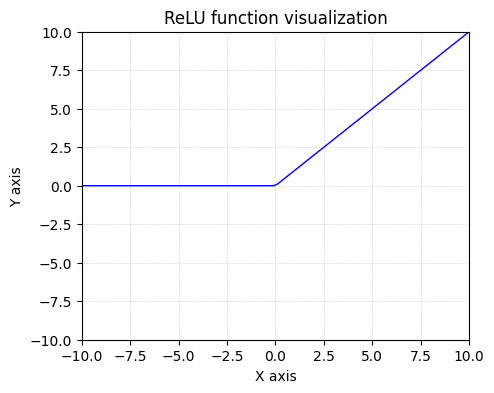

In [6]:
# ReLU that works on both single values and arrays (vectors)

def relu_manual(x):
    """
    Implements RelU: f(x)
    Works for both single values and numpy arrays
    """
    # Handling scalar inputs
    if np.isscalar(x):
        return np.maximum(0,x)


    r_x = []
    for i in x:
        a = np.maximum(0,i)
        r_x.append(a)
    return np.array(r_x)

# Test on single values
test_values = [-2, -1, 0, 1, 2]
one_value = 56
print(f"ReLU({test_values}) = {relu_manual(test_values)}")
print(f"ReLU({one_value}) = {relu_manual(one_value)}")

# Lets create a scatter plot with the ReLU function

from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(5,4))
ax.axis((-10,10,-10,10))
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title('ReLU function visualization')


# Add nice gridlines
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3, color='gray')
ax.set_axisbelow(True)  # Put grid behind the plot

# ReLU values
x_values = np.linspace(-10,10,100)
y_values = relu_manual(x_values)
ax.plot(x_values,y_values,"-",color="blue",linewidth=1,label="Decision Boundary")

### Step 5: Building a Neural Network Layer
Now let's combine what we've learned about affine transformations and ReLU to create a simple neural network layer. A layer performs:
1. Affine transformation: $h = Wx + b$
2. Activation: $output = ReLU(h)$
This is the fundamental building block of neural networks

In [7]:
# Building a Neural Network from scratch

class SimpleLayer:
  """
  A simple neural network layer with affine transformation and ReLU activation
  """
  def __init__(self, input_dim, output_dim):
    """
    Initialize the layer with random weights and biases
    input_dim: Number of input features/neaurons feeding into this layer
    output_dim: Number of output neurons this layer will produce
    """
    # Initialize wights and baises with small random numbers
    # W here is created one row per output neuron (perceptron) --> SUPER IMPORTANT
    self.W = np.random.rand(output_dim, input_dim) * 0.1
    self.b = np.random.rand(output_dim) * 0.1

  def forward(self, x):
    """
    Forward pass through the neural network layer
    x: input vector (numpy array)
    returns: activated output
    """
    print(f"W:{self.W}")
    print(f"b:{self.b}")
    t = np.dot(self.W, x) + self.b # Perform transformation
    if np.isscalar(t):
        return np.maximum(0,t)
    r_t = []
    for i in t:
        a = np.maximum(0,i)
        r_t.append(a)
    return np.array(r_t)

# Test the layer
np.random.seed(42)
layer1 = SimpleLayer(input_dim=3, output_dim=4)
test_input = np.array([1.0,-0.5,2.0])
output = layer1.forward(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Input values: {test_input}")
print(f"Output shape: {output.shape}")
print(f"Output values: {output}")


W:[[0.03745401 0.09507143 0.07319939]
 [0.05986585 0.01560186 0.01559945]
 [0.00580836 0.08661761 0.0601115 ]
 [0.07080726 0.00205845 0.09699099]]
b:[0.08324426 0.02123391 0.0181825  0.01834045]
Input shape: (3,)
Input values: [ 1.  -0.5  2. ]
Output shape: (4,)
Output values: [0.21956135 0.10449773 0.10090505 0.28210045]


### Step 6: Building my first neuron from scratch

We have finally started working above on some of the key components of a neural network in this case it is the forward pass that includes building the perceptron with the added weights, biases and the ReLu activation.

Now lets go one more step and add two more features which are:
1. Backward pass
2. Loss calculation

The first formula we need to understand is backward pass which is the implementation of backpropagation and gradient descent. The first thing we need to know about this formula is that it is an implementation of the chain-rule we all learn in calculus, which mathematically can be described as follows:

if $y = f(g(x))$, then $\frac{dy}{dx} = f^{'}(g(x)) * g^{'}(x))$. If we take our simple Neuron examle below, for our neuron to learn we need to calculate the derivate of the loss result based on changes in weights and other parameters of the Neuron! Thus we get:

$$
\frac{\partial L}{\partial w}
= \frac{\partial L}{\partial a}
\cdot \frac{\partial a}{\partial z}
\cdot \frac{\partial z}{\partial w}.
$$
Now a neuran can be defined as follows
where, $\frac{\partial L}{\partial a} = $,

In [8]:
class Neuron:

  """
  Forward pass
  Backward pass (Backpropagation)
  Loss function
  """
  def __init__(self, input_dim):
    # initialize weights and bias with small random values
    self.W = np.random.randn(input_dim) * 0.1
    self.b = 0.0

    # Store values for backward pass
    self.last_input = None
    self.last_z = None # pre-activation value
    self.last_output = None

  def forward(self, x):
    """Compute output for input x"""
    # Store for backward pass
    self.last_input = x

    # Affine transformation
    z = np.dot(self.W,x) + self.b
    self.last_z = z

    # Implement activation in this case it would be sigmoid
    h = np.where(z >= 0, 1/(1+np.exp(-z), np.exp(z)/ (1+np.exp(z))))
    self.last_output = h
    return self.last_output

  def compute_loss(self, y_true):
    """ Compute squared error loss """
    if self.last_output is None:
      raise ValueError("Must call forward() first")

    # Simple squared error: (prediction - target)^2
    loss = 0.5 * np.square(self.last_output - y_true)
    return loss

  def backward(self, y_true, learning_rate=0.01):
    """
    Compute gradients and update weights
    y_true: target value
    learning_rate" step size for weight updates
    """
    if self.last_output is None:
      raise ValueError("Must call forward() first")





# Test the neuron
neuron = Neuron(input_dim=2)
test_x = np.array([1.0, -0.5])

# Implement forward pass
print(f"Neuron created with weights:{neuron.W}")

Neuron created with weights:[ 0.02419623 -0.19132802]
